In [ ]:
install.packages('Refs/dd_Smes_g4/BSgenome.S2F2.planmine.g4_1.0.0.tar.gz', 
                 repos = NULL, type="source")

In [ ]:
library(BSgenome)
library(Biostrings)   
library(GenomeInfoDb)
library(rtracklayer)
library(GenomicFeatures)
library(AnnotationDbi)
library(ArchR)
library(AnnotationForge) #"Only need for making annotation"
library(OrganismDbi)
library(ensembldb)
library(dplyr)
library(tidyverse)
library(Seurat)
library(SingleCellExperiment)
library(zellkonverter )
library(anndata)
#library(DropletUtils)
library(BSgenome.S2F2.planmine.g4)
library('scrattch.io')

# Data import and preprocessing

## Set up the reference

In [2]:
addArchRThreads(threads = 1) 

Setting default number of Parallel threads to 1.



In [4]:
db <- ensDbFromGtf(gtf="Refs/dd_Smes_g4/Smes_SMESG_g4_hc_edit_v04.gtf", 
                   organism = "Schmidtea Mediterranean", genomeVersion = "v01", version = 1)
edb <- EnsDb(db)
rm(db)

Importing GTF file ... 
OK

Processing genes ... 

Warning message in ensDbFromGRanges(GTF, outfile = outfile, path = path, organism = organism, :
" I'm missing column(s): 'gene_name','entrezid','gene_biotype'. The corresponding database column(s) will be empty!"
 Attribute availability:

  o gene_id ... OK

  o gene_name ... Nope

  o entrezid ... Nope

  o gene_biotype ... Nope

OK

Processing transcripts ... 

Warning message in ensDbFromGRanges(GTF, outfile = outfile, path = path, organism = organism, :
"I'm missing column(s): 'transcript_name'. The corresponding database columns will be empty!"
 Attribute availability:

  o transcript_id ... OK

  o gene_id ... OK

  o source ... OK

  o transcript_name ... Nope

OK

Processing exons ... 
OK

Processing chromosomes ... 
Fetch seqlengths from ensembl ... 


Error in readLines(curl(my_url)) : 
  Server denied you to change to the given directory
Error in readLines(curl(my_url)) : 
  Server denied you to change to the given directory


Warning message in .getSeqlengthsFromMysqlFolder(organism = organism, ensembl = ensemblVersion, :
"Can not get the sequence lengths from Ensembl or Ensemblgenomes. Seqinfo will lack the sequence lengths."
FAIL

Warning message in tryGetSeqinfoFromEnsembl(organism, version, seqnames = chroms$seq_name):
"Unable to retrieve sequence lengths from Ensembl."
OK

Processing metadata ... 
OK

Generating index ... 
OK

  -------------

Verifying validity of the information in the database:

Checking transcripts ... 
OK
Checking exons ... 
OK



In [ ]:
genome <- getBSgenome(BSgenome.S2F2.planmine.g4)
chrRanges <- as( seqinfo(genome), "GRanges" )

addArchRChrPrefix(chrPrefix = FALSE)

genomeAnno <- createGenomeAnnotation( genome=genome, chromSizes=chrRanges )

In [ ]:
gene.ranges <- genes(edb)
gene.ranges = as(gene.ranges, "data.frame")
tmp2<- gene.ranges[,-c(7,8,9,10,11)]
tmp <- gene.ranges[,-c(7,8,9,10,11)]
rownames(tmp) <- NULL
rownames(tmp2) <- NULL
gene.ranges = makeGRangesFromDataFrame(tmp,keep.extra.columns=TRUE) 
tmp2.ranges = makeGRangesFromDataFrame(tmp2,keep.extra.columns=TRUE) 
gene.ranges$symbol <- gene.ranges$gene_id
length(tmp2.ranges$gene_id)
tss.ranges <- resize(tmp2.ranges, 1, "start")
exon.ranges = exons(edb)
exon.ranges$gene_id <- exon.ranges$exon_id
exon.ranges = as(exon.ranges, "data.frame")
rownames(exon.ranges) <- NULL
exon.ranges$gene_id <- sub(".[^.]+$", "", exon.ranges$exon_id)
exon.ranges$symbol <-  sub(".[^.]+$", "", exon.ranges$exon_id)
tmp1 <- exon.ranges[,-c(6)]
rownames(tmp1) <- NULL
exon.ranges = makeGRangesFromDataFrame(tmp1,keep.extra.columns=TRUE) 
exon.ranges$symbol <- exon.ranges$gene_id

geneAnnotation = createGeneAnnotation(
  TSS = tss.ranges, 
  exons = exon.ranges, 
  genes = gene.ranges
)

In [ ]:
genomeAnno$chromSizes <- genomeAnno$chromSizes[unique(seqnames(tss.ranges))]

In [ ]:
setwd( "ArchROutputs/Smed/" )
getwd()

## Read in the ATAC data

In [ ]:
# input Files 
inputFiles <- c(S2F2_uncut1_g4_v03="../../FragmentFiles/Smed/S2F2_CC1_g4.tsv.gz",
            S2F2_uncut2_g4_v03="../../FragmentFiles/Smed/S2F2_CC2_g4.tsv.gz",
            S2F2_uncut3_g4_v03="../../FragmentFiles/Smed/S2F2_CC3_g4.tsv.gz")
inputFiles
names(inputFiles)

In [ ]:
inputFiles_asexual <- c(Smed_uncut_g4_v03="../../FragmentFiles/Smed/Smed_uncut_g4.tsv.gz",
            Smed_cut_g4_v03="../../FragmentFiles/Smed/Smed_cut_g4.tsv.gz")
inputFiles_asexual
names(inputFiles_asexual)

In [ ]:
# This is the cutoff for sexuals 
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  geneAnnotation = geneAnnotation,
  genomeAnnotation = genomeAnno,
  minTSS = 1, #Dont set this too high because you can always increase later
  minFrags = 700, # had 600 before
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  force = TRUE
)

In [ ]:
# This is the cutoff for sexuals 
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles_asexual,
  sampleNames = names(inputFiles_asexual),
  geneAnnotation = geneAnnotation,
  genomeAnnotation = genomeAnno,
  minTSS = 1.8, #Dont set this too high because you can always increase later
  minFrags = 1000, # had 600 before
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  force = TRUE
)

# Add RNA data

In [6]:
# Now, let's integrate RNA data in 
bcRNA <- readLines( "../../Refs/737K-arc-v1-RNA.txt" )
bcATAC <- readLines( "../../Refs/737K-arc-v1.atac.revcomp.unsrt.txt")

Warning message in readLines("./737K-arc-v1-RNA.txt"):
"incomplete final line found on './737K-arc-v1-RNA.txt'"
Warning message in readLines("./737K-arc-v1.atac.revcomp.unsrt.txt"):
"incomplete final line found on './737K-arc-v1.atac.revcomp.unsrt.txt'"


In [7]:
S2F21 <- ReadMtx(mtx="../../GEXCounts/Smed/STARsolo/S2F21_uncut/Solo.out/GeneFull/raw/matrix.mtx",
                cells="../../GEXCounts/Smed/STARsolo/S2F21_uncut/Solo.out/GeneFull/raw/barcodes.tsv",
                features="../../GEXCounts/Smed/STARsolo/S2F21_uncut/Solo.out/GeneFull/raw/features.tsv",
                feature.column=2, mtx.transpose=F )

colnames(S2F21) <- paste0( "S2F2_uncut1_g4_v03#",  data.frame( bcRNA, bcATAC, row.names=1 )[colnames(S2F21),] )

In [8]:
S2F22 <- ReadMtx(mtx="../../GEXCounts/Smed/STARsolo/S2F22_uncut/Solo.out/GeneFull/raw/matrix.mtx",
                cells="../../GEXCounts/Smed/STARsolo/S2F22_uncut/Solo.out/GeneFull/raw/barcodes.tsv",
                features="../../GEXCounts/Smed/STARsolo/S2F22_uncut/Solo.out/GeneFull/raw/features.tsv",
                feature.column=1, mtx.transpose=F )

colnames(S2F22) <- paste0( "S2F2_uncut2_g4_v03#",  data.frame( bcRNA, bcATAC, row.names=1 )[colnames(S2F22),] )

In [9]:
S2F23 <- ReadMtx(mtx="../../GEXCounts/Smed/STARsolo/S2F23_uncut/Solo.out/GeneFull/raw/matrix.mtx",
                cells="../../GEXCounts/Smed/STARsolo/S2F23_uncut/Solo.out/GeneFull/raw/barcodes.tsv",
                features="../../GEXCounts/Smed/STARsolo/S2F23_uncut/Solo.out/GeneFull/raw/features.tsv",
                feature.column=1, mtx.transpose=F )

colnames(S2F23) <- paste0( "S2F2_uncut3_g4_v03#",  data.frame( bcRNA, bcATAC, row.names=1 )[colnames(S2F23),] )

In [10]:
Smed_uncut <- ReadMtx(mtx="../../GEXCounts/Smed/STARsolo/Smed_uncut/Solo.out/GeneFull/raw/matrix.mtx",
                cells="../../GEXCounts/Smed/STARsolo/Smed_uncut/Solo.out/GeneFull/raw/barcodes.tsv",
                features="../../GEXCounts/Smed/STARsolo/Smed_uncut/Solo.out/GeneFull/raw/features.tsv",
                feature.column=1, mtx.transpose=F )

colnames(Smed_uncut) <- paste0( "Smed_uncut_g4_v03#",  data.frame( bcRNA, bcATAC, row.names=1 )[colnames(Smed_uncut),] )

In [11]:
Smed_cut <- ReadMtx(mtx="../../GEXCounts/Smed/STARsolo/Smed_cut/Solo.out/GeneFull/raw/matrix.mtx",
                cells="../../GEXCounts/Smed/STARsolo/Smed_cut/Solo.out/GeneFull/raw/barcodes.tsv",
                features="../../GEXCounts/Smed/STARsolo/Smed_cut/Solo.out/GeneFull/raw/features.tsv",
                feature.column=1, mtx.transpose=F )

colnames(Smed_cut) <- paste0( "Smed_cut_g4_v03#",  data.frame( bcRNA, bcATAC, row.names=1 )[colnames(Smed_cut),] )

In [12]:
Smes_Smed_all <- cbind(S2F21,S2F22,S2F23,Smed_uncut,Smed_cut)
seRNA <- SummarizedExperiment(list(counts=Smes_Smed_all[geneAnnotation$genes$symbol,colnames(Smes_Smed_all) %bcin% Smes_Smed$cellNames]), rowRanges=geneAnnotation$genes)

In [13]:
Smes_Smed <- addGeneExpressionMatrix(input=Smes_Smed, seRNA=seRNA,force=TRUE)

ArchR logging to : ArchRLogs/ArchR-addGeneExpressionMatrix-723c5c4e42a2-Date-2022-05-21_Time-12-00-02.log
If there is an issue, please report to github with logFile!

Overlap w/ scATAC = 1

2022-05-21 12:00:02 : 

Overlap Per Sample w/ scATAC : S2F2_uncut1_g4_v03=1976,S2F2_uncut2_g4_v03=2519,S2F2_uncut3_g4_v03=2801,Smed_cut_g4_v03=8297,Smed_uncut_g4_v03=6458

2022-05-21 12:00:02 : 

2022-05-21 12:00:17 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-05-21 12:00:18 : Adding Smed_cut_g4_v03 to GeneExpressionMatrix for Chr (1 of 460)!, 0.022 mins elapsed.

2022-05-21 12:00:21 : Adding Smed_cut_g4_v03 to GeneExpressionMatrix for Chr (2 of 460)!, 0.058 mins elapsed.

2022-05-21 12:00:23 : Adding Smed_cut_g4_v03 to GeneExpressionMatrix for Chr (3 of 460)!, 0.093 mins elapsed.

2022-05-21 12:00:26 : Adding Smed_cut_g4_v03 to GeneExpressionMatrix for Chr (4 of 460)!, 0.143 mins elapsed.

2022-05-21 12:00:28 : Adding Smed_cut_g4_v03 to GeneExpressionMatrix for Chr (5 of 460)!, 0.176 min

In [ ]:
# How to save ArchR project
saveArchRProject(
  ArchRProj = Smes_Smed,
  outputDirectory = "ArchRProjs/init_proj",
  overwrite = TRUE,
  load = TRUE,
  dropCells = FALSE,
  logFile = createLogFile("saveArchRProject"),
  threads = getArchRThreads()
)

# QC

In [15]:
# Filter cells 
Smes_Smed_filtered <- Smes_Smed[!is.na(Smes_Smed$Gex_nUMI) & Smes_Smed$Gex_nUMI >200]
# Doublet removal 
Smes_Smed_filtered <- addDoubletScores(Smes_Smed_filtered)
Smes_Smed_filtered <- filterDoublets(Smes_Smed_filtered)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-723c67673487-Date-2022-05-21_Time-13-25-45.log
If there is an issue, please report to github with logFile!

2022-05-21 13:25:46 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-05-21 13:25:46 : Smed_cut_g4_v03 (1 of 5) :  Computing Doublet Statistics, 0 mins elapsed.

Smed_cut_g4_v03 (1 of 5) : UMAP Projection R^2 = 0.99764

Smed_cut_g4_v03 (1 of 5) : UMAP Projection R^2 = 0.99764

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
2022-05-21 13:36:40 : Smed_uncut_g4_v03 (2 of 5) :  Computing Doublet Statistics, 10.908 mins elapsed.

Smed_uncut_g4_v03 (2 of 5) : UMAP Projection R^2 = 0.9979

Smed_uncut_g4_v03 (2 of 5) : UMAP Projection R^2 = 0.9979

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
2022-05-21 13:47:07 : S2F2_uncut3_g4_v03 (3 of 5) :  Computing Doublet Statistics, 21.363 mins elapsed.

S2F2_uncut3_g4_

# Clustering

In [16]:
Smes_Smed_int <- addIterativeLSI(
    ArchRProj = Smes_Smed_filtered,
    useMatrix = "TileMatrix", 
    name = "IterativeLSI", 
    iterations = 3, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(2), 
        sampleCells = 15000,
        n.start = 10
    ), 
    varFeatures = 25000, 
    dimsToUse = 1:30,
    force = TRUE,
    seed = 10,
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-723cf510499-Date-2022-05-21_Time-14-14-29.log
If there is an issue, please report to github with logFile!

2022-05-21 14:14:34 : Computing Total Across All Features, 0.069 mins elapsed.

2022-05-21 14:14:43 : Computing Top Features, 0.22 mins elapsed.

###########
2022-05-21 14:14:44 : Running LSI (1 of 3) on Top Features, 0.239 mins elapsed.
###########

2022-05-21 14:14:44 : Sampling Cells (N = 10002) for Estimated LSI, 0.24 mins elapsed.

2022-05-21 14:14:44 : Creating Sampled Partial Matrix, 0.24 mins elapsed.

2022-05-21 14:14:44 : Sampling Cells (N = 10002) for Estimated LSI, 0.24 mins elapsed.

2022-05-21 14:15:20 : Computing Estimated LSI (projectAll = TRUE), 0.848 mins elapsed.

2022-05-21 14:15:29 : Projecting Matrices with LSI-Projection (Granja* et al 2019), 0.996 mins elapsed.

2022-05-21 14:15:36 : Identifying Clusters, 1.116 mins elapsed.

2022-05-21 14:15:53 : Identified 25 Clusters, 1.393 mins elaps

In [17]:
# #LSI-RNA
Smes_Smed_int <- addIterativeLSI(
    ArchRProj = Smes_Smed_int,
    iterations = 3,
    clusterParams = list(
      resolution = 2, 
      sampleCells = 15000,
      n.start = 10
    ),
    saveIterations = FALSE,
    useMatrix = "GeneExpressionMatrix", 
    depthCol = "Gex_nUMI",
    varFeatures = 5000,
    firstSelection = "Var",
    binarize = FALSE,
    name = "LSI_RNA",
    force = TRUE
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-723cc6aef7d-Date-2022-05-21_Time-14-36-54.log
If there is an issue, please report to github with logFile!

2022-05-21 14:36:58 : Computing Variability Across All Features, 0.071 mins elapsed.

2022-05-21 14:37:12 : Computing Variable Features, 0.31 mins elapsed.

###########
2022-05-21 14:37:14 : Running LSI (1 of 3) on Top Features, 0.328 mins elapsed.
###########

2022-05-21 14:37:14 : Sampling Cells (N = 10002) for Estimated LSI, 0.329 mins elapsed.

2022-05-21 14:37:14 : Creating Sampled Partial Matrix, 0.329 mins elapsed.

2022-05-21 14:37:14 : Sampling Cells (N = 10002) for Estimated LSI, 0.329 mins elapsed.

2022-05-21 14:37:55 : Computing Estimated LSI (projectAll = TRUE), 1.028 mins elapsed.

2022-05-21 14:38:04 : Projecting Matrices with LSI-Projection (Granja* et al 2019), 1.176 mins elapsed.

2022-05-21 14:38:13 : Identifying Clusters, 1.311 mins elapsed.

2022-05-21 14:38:28 : Identified 25 Clusters, 1.

In [18]:
Smes_Smed_int <- addCombinedDims(Smes_Smed_int, reducedDims = c("IterativeLSI", "LSI_RNA"), name =  "LSI_Combined")

In [19]:
# Harmony for combined manifold 
Smes_Smed_int <- addHarmony(
    ArchRProj = Smes_Smed_int,
    reducedDims = "LSI_Combined",
    name = "Combined-Harmony",
    groupBy = "Sample",
    force = TRUE
)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



In [66]:
# Clustering 
Smes_Smed_int <- addClusters(
    input = Smes_Smed_int,
    reducedDims = "Combined-Harmony",
    method = "Seurat",
    name = "Clusters_Comb",
    resolution = 1.2, 
    maxClusters = 34,
    force = TRUE
)

ArchR logging to : ArchRLogs/ArchR-addClusters-723c281079b4-Date-2022-05-21_Time-22-06-34.log
If there is an issue, please report to github with logFile!

Overriding previous entry for Clusters_Comb

2022-05-21 22:06:34 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.001 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 20659
Number of edges: 989813

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9267
Number of communities: 35
Elapsed time: 2 seconds


2022-05-21 22:07:01 : Testing Biased Clusters, 0.452 mins elapsed.

2022-05-21 22:07:01 : Testing Outlier Clusters, 0.454 mins elapsed.

2022-05-21 22:07:01 : Identified more clusters than maxClusters allowed (n = 0). Merging clusters to maxClusters (n = 34).
If this is not desired set maxClusters = NULL!, 0.454 mins elapsed.

2022-05-21 22:07:01 : Assigning Cluster Names to 34 Clusters, 0.455 mins elapsed.

2022-05-21 22:07:01 : Finished addClusters, 0.456 mins elapsed.



In [67]:
Smes_Smed_int <- addUMAP(Smes_Smed_int, reducedDims = "Combined-Harmony", name = "UMAP_Combined", minDist = 0.5, force = TRUE)

22:07:01 UMAP embedding parameters a = 0.583 b = 1.334

22:07:01 Read 20659 rows and found 60 numeric columns

22:07:01 Using Annoy for neighbor search, n_neighbors = 40

22:07:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:07:03 Writing NN index file to temp file /tmp/RtmptL1tBA/file723c3a4e68d8

22:07:03 Searching Annoy index using 6 threads, search_k = 4000

22:07:05 Annoy recall = 100%

22:07:06 Commencing smooth kNN distance calibration using 6 threads

22:07:08 Initializing from normalized Laplacian + noise

22:07:09 Commencing optimization for 200 epochs, with 1276620 positive edges

22:07:18 Optimization finished

22:07:18 Creating temp model dir /tmp/RtmptL1tBA/dir723c664be7d2

22:07:18 Creating dir /tmp/RtmptL1tBA/dir723c664be7d2

22:07:20 Changing to 

In [68]:
p <- plotEmbedding(Smes_Smed_int, name = "Clusters_Comb", embedding = "UMAP_Combined", size = 0.5, labelAsFactors=F, labelMeans=F)


ArchR logging to : ArchRLogs/ArchR-plotEmbedding-723c25d811fd-Date-2022-05-21_Time-22-07-20.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-723c25d811fd-Date-2022-05-21_Time-22-07-20.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-723c11b662cb-Date-2022-05-21_Time-22-07-50.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-723c11b662cb-Date-2022-05-21_Time-22-07-50.log



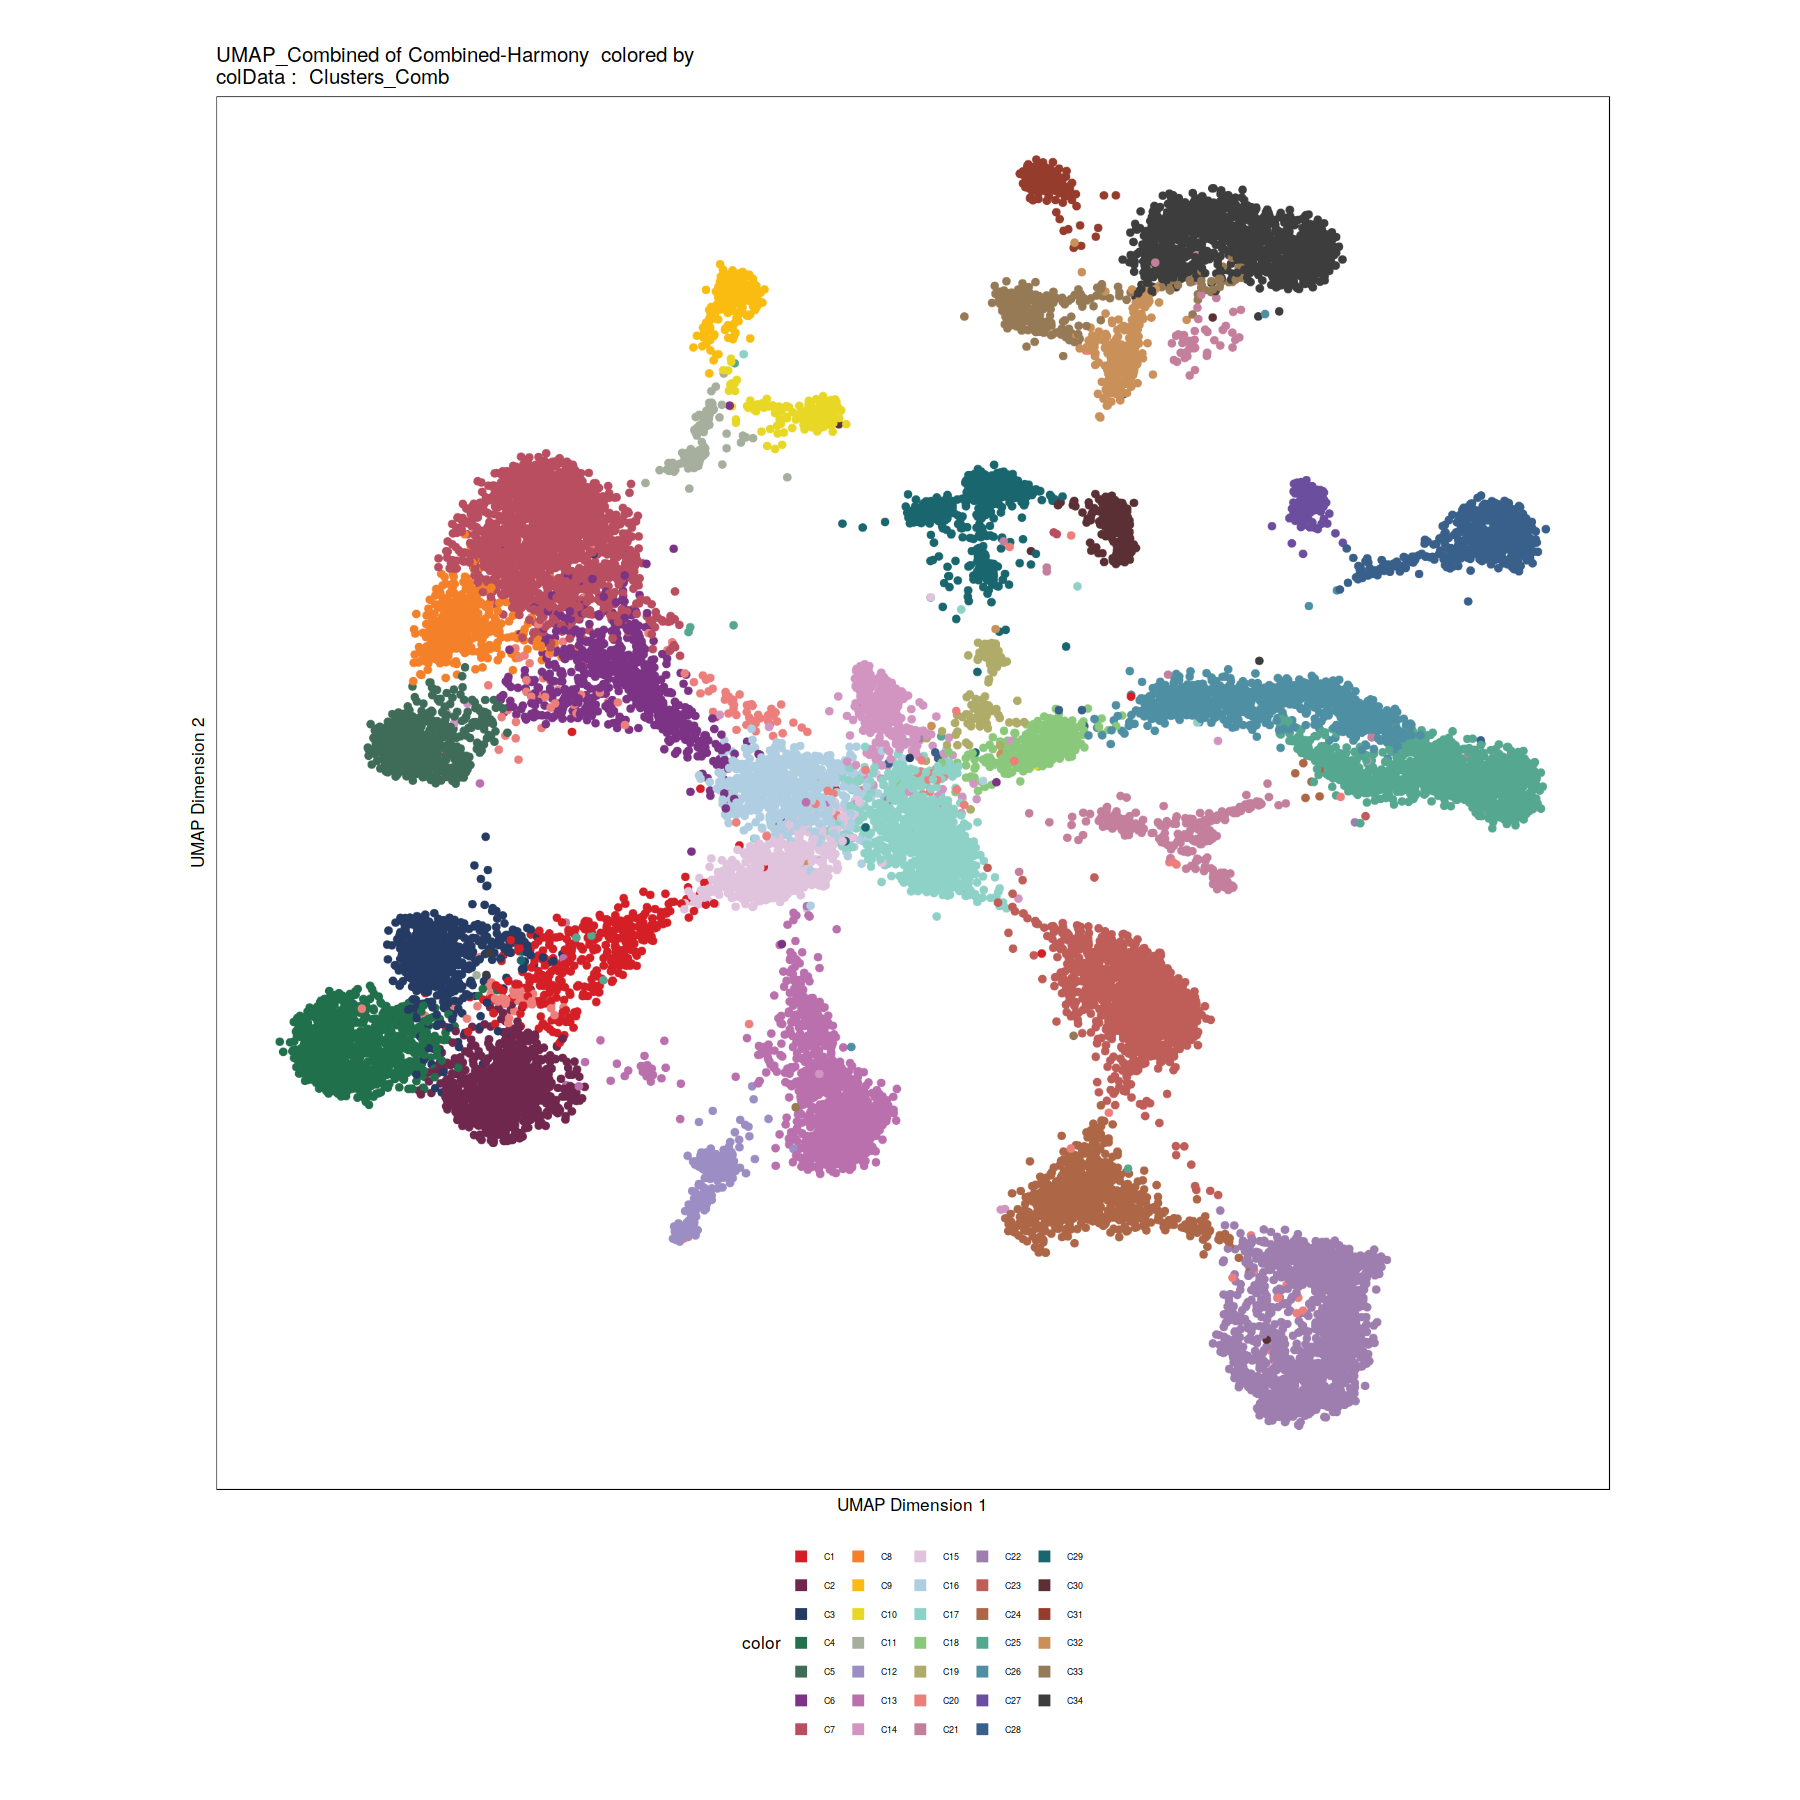

In [79]:
options(repr.plot.width=15, repr.plot.height=15)

p

In [ ]:
p <- plotEmbedding(Smes_Smed_int, name = "Sample", embedding = "UMAP_Combined", size = 0.5, labelAsFactors=F, labelMeans=F)

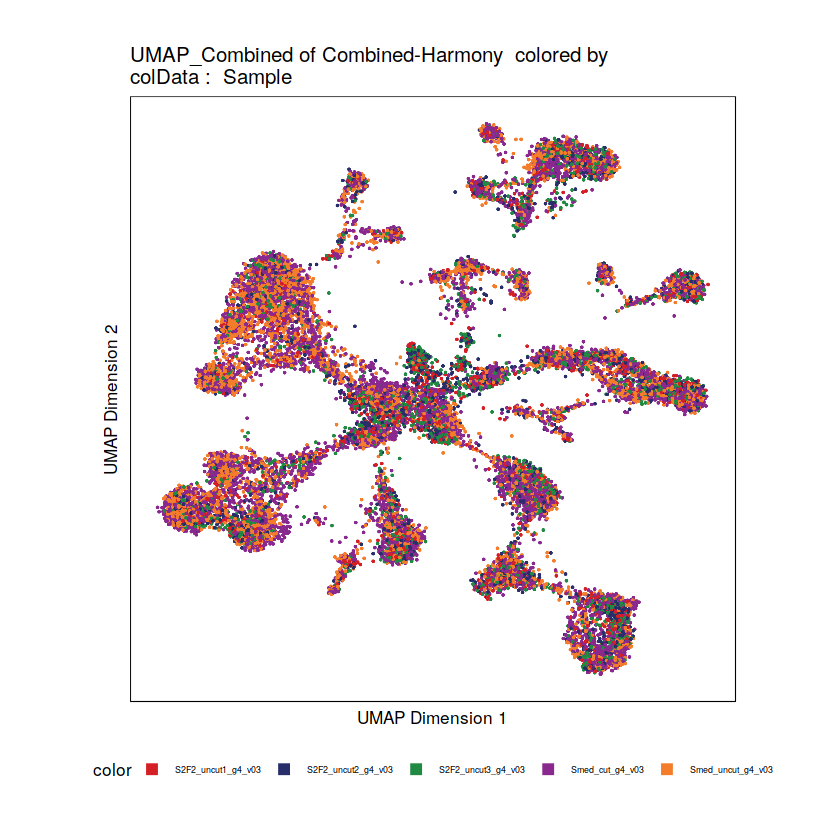

In [70]:
p

In [71]:
Smes_Smed_int <- addImputeWeights(Smes_Smed_int,reducedDims = "LSI_Combined")

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-723c4ad6b238-Date-2022-05-21_Time-22-07-55.log
If there is an issue, please report to github with logFile!

2022-05-21 22:07:55 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



In [77]:
saveArchRProject(
  ArchRProj = Smes_Smed_int,
  outputDirectory = "ArchRProjs/filtered_clustered",
  overwrite = TRUE,
  load = TRUE,
  dropCells = FALSE,
  logFile = createLogFile("saveArchRProject"),
  threads = getArchRThreads()
)

Copying ArchRProject to new outputDirectory : /media/gary/Chew/Sch_multiome/chromap_all/Smed_Smes_g4_filtered_RNA_v03_5_19

Copying Arrow Files...

Copying Arrow Files (1 of 5)

Copying Arrow Files (2 of 5)

Copying Arrow Files (3 of 5)

Copying Arrow Files (4 of 5)

Copying Arrow Files (5 of 5)

Getting ImputeWeights

Dropping ImputeWeights...

Copying Other Files...

Copying Other Files (1 of 8): Embeddings

Copying Other Files (2 of 8): IterativeLSI

Copying Other Files (3 of 8): LSI_RNA

Copying Other Files (4 of 8): S2F2_uncut1_g4_v03

Copying Other Files (5 of 8): S2F2_uncut2_g4_v03

Copying Other Files (6 of 8): S2F2_uncut3_g4_v03

Copying Other Files (7 of 8): Smed_cut_g4_v03

Copying Other Files (8 of 8): Smed_uncut_g4_v03

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
    

class: ArchRProject 
outputDirectory: /media/gary/Chew/Sch_multiome/chromap_all/Smed_Smes_g4_filtered_RNA_v03_5_19 
samples(5): Smed_cut_g4_v03 Smed_uncut_g4_v03 S2F2_uncut3_g4_v03
  S2F2_uncut2_g4_v03 S2F2_uncut1_g4_v03
sampleColData names(1): ArrowFiles
cellColData names(18): Sample TSSEnrichment ... DoubletEnrichment
  Clusters_Comb
numberOfCells(1): 20659
medianTSS(1): 2.686
medianFrags(1): 2188

In [ ]:
# Impute the gene scores to help with low coverage
gsmat <- getMatrixFromProject( Smes_Smed_int, useMatrix="GeneScoreMatrix" )
imp <- imputeMatrix( assay( momat, 'z' ), getImputeWeights(Smes_Smed_int) )

sce <- SingleCellExperiment( list(counts=imp) )
rownames(sce) <- rowData( gsmat )$name
colData(sce) <- colData( gsmat )[,c("SeuratClusters")]
# Export the data
adata <- SCE2AnnData( sce )
anndata::write_h5ad( adata, "Smed.imputed_genescores.h5ad" )

rm( momat )
rm( sce )
rm( adata )

# Add annotations from SAMap

In [ ]:
annots <- read.csv( '../../Metadata/Smed.final_cluster_annots.csv', 
                    header=TRUE )
head(annots)

In [ ]:
Smes_Smed_int <- addCellColData( Smes_Smed_int, data=annots$GroupFigure, name='GroupFigure',
                                 cells=rownames(annots), force=TRUE )

In [ ]:
p <- plotEmbedding(
    Smes_Smed_int, 
    colorBy = "cellColData", 
    name = "GroupFigure", 
    embedding = "UMAP_Combined"
)
options(repr.plot.width=20, repr.plot.height=12)

p <- p + theme_set(theme_classic(base_size = 15)) + labs(title = "", color = "Clusters") 
p

# Add in the peak matrix

In [ ]:
peaks <- read.table("../../Peaks/Smed.merged_peaks.narrowPeak")[,c("V1","V2","V3","V10")]
peaks <- GRanges(peaks$V1, IRanges(peaks$V2 + 1, peaks$V3), score = peaks$V10)
peaks

In [ ]:
Smes_Smed_int <- addPeakSet( Smes_Smed_int, peaks, genomeAnno, force=T )
Smes_Smed_int <- addPeakMatrix( Smes_Smed_int )
Smes_Smed_int

In [ ]:
# Get GC-matched background peaks for deviations
Smes_Smed_int <- addBgdPeaks( Smes_Smed_int, method="ArchR" )

# Export

In [ ]:
pkmat <- getMatrixFromProject( Smes_Smed_int, useMatrix="PeakMatrix" )
sce <- SingleCellExperiment( list(counts=assay(pkmat)) )
rownames(sce) <- rowData( pkmat )$name
colData(sce) <- colData( pkmat )[,c("GroupFigure")]

adata <- SCE2AnnData( sce )
anndata::write_h5ad( adata, "Smed.peaks.h5ad" )

rm( pkmat )
rm( sce )
rm( adata )

In [ ]:
# Export the peak set again just in case ArchR does any weird rearranging/reformatting
peaks <- getPeakSet( Smes_Smed_int )
chr_order <- sort(seqlevels(peaks))
reordered_features <- list()
for(chr in chr_order)
    reordered_features[[chr]] = peaks[seqnames(peaks) == chr]
reordered_features <- Reduce("c", reordered_features)
names(reordered_features) <- sprintf("Peak%d", 1:length(reordered_features))
write.csv(as.data.frame(reordered_features), 'Smed.peaks.csv', quote=FALSE)
reordered_features

In [ ]:
write.table( assay( getBgdPeaks( Smes_Smed_int ) ), file='Smed.bgd_peaks.txt', 
             row.names=FALSE, col.names=FALSE )

# Annotate motif hits in peaks

In [ ]:
library( universalmotif )

In [ ]:
# Read in the PFMs
modisco <- read_meme( '../../motif_clustering_data/all_motif_clusters.annot.meme' )
modisco <- convert_motifs( modisco, 'TFBSTools-PWMatrix' )
modisco

In [ ]:
# Update the names so it works with ArchR
v <- list()
for (m in modisco){
    v[TFBSTools::name(m)] <- m }
modisco <- do.call(TFBSTools::PWMatrixList, v)
modisco

In [ ]:
Smes_Smed_int <- addMotifAnnotations( Smes_Smed_int, motifPWMs=modisco, 
                                      name="ModiscoMotifs", 
                                      force=TRUE, cutOff=1e-5 )

# Export raw motif hits

In [ ]:
matches <- readRDS( getPeakAnnotation( Smes_Smed_int, 'ModiscoMotifs' )$Matches )
sce <- SingleCellExperiment( list(counts=assay(matches)) )
rowData(sce) <- rowData(matches)
colnames(sce) <- colnames(matches)

adata <- SCE2AnnData( sce )
anndata::write_h5ad( adata, "../../FilteredPeakMotifHits/Smed.raw_peak_motif_hits.h5ad" )

rm( matches )
rm( sce )
rm( adata )

In [ ]:
saveArchRProject( Smes_Smed_int, outputDirectory="ArchRProjs/Smed_final_ArchR_proj/" )